# Traning Model 2
### Chengming He

In [2]:
import sys  
sys.path.insert(0, '../lib')
import tensorflow as tf
import numpy as np
import pandas as pd
import sklearn
from tensorflow import keras
from tqdm import tqdm
import os
import pandas as pd
import numpy as np
from PIL import Image
import random
import time
import matplotlib.pyplot as plt
from utils.image_generator import ImageGenerator
from utils.model import NoisyNet
from utils.trainer import trainer
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

## 1. Train label cleaning network on Densenet

### 1.1 Loading data

In [12]:
clean = pd.read_csv('../../proj3/train_data/clean_labels.csv',header=None)
noisy = pd.read_csv('../../proj3/train_data/noisy_labels.csv',header=None)
print(len(clean),len(noisy))

10000 50000


In [15]:
train_cleaner = "../../proj3/train_data/images/train_label_cleaning" 
train_classifier = "../../proj3/train_data/images/train_image_classification" 

In [16]:
##training for label cleaning
image_list=[]
clean_label_list=[]
noisy_label_list=[]
for file in tqdm(os.listdir(train_cleaner)):
#     print("Reading folder {}".format(file))
    filename = os.fsdecode(file)
    filenum = int(filename[:5])
    image_list.append(np.array(Image.open(os.path.join(train_cleaner,file))))
    clean_label_list.append(int(clean.iloc[filenum-1]))
    noisy_label_list.append(int(noisy.iloc[filenum-1]))

100%|███████████████████████████████████| 10000/10000 [00:08<00:00, 1161.14it/s]


In [17]:
X=np.array(image_list)
y_noisy=np.array(noisy_label_list).reshape(len(noisy_label_list),1)
y_clean=np.array(clean_label_list)
print("Image dimensions: ",X[0].shape)
print("Number of labels: ",np.unique(y_noisy))

Image dimensions:  (32, 32, 3)
Number of labels:  [0 1 2 3 4 5 6 7 8 9]


### 1.2 Loading data
Split clean data into train, validation and test.

In [18]:
###Train, validation, and test split of the clean labled images
np.random.seed(0)
train_frac = 0.7
val_frac = 0.2
test_frac = 0.1
index = np.arange(len(X));np.random.shuffle(index)
train_index,val_index,test_index = index[:int(train_frac*len(X))],index[int(train_frac*len(X)):int((train_frac+val_frac)*len(X))],index[int((train_frac+val_frac)*len(X)):]
X_train, X_val,X_test = X[train_index],X[val_index],X[test_index]
y_noisy_train, y_noisy_val, y_noisy_test = y_noisy[train_index],y_noisy[val_index], y_noisy[test_index]
y_clean_train, y_clean_val, y_clean_test = y_clean[train_index],y_clean[val_index], y_clean[test_index]
print(len(X_train),len(y_noisy_train),len(y_clean_train),len(X_val),len(y_noisy_val),len(y_clean_val),len(X_test),len(y_noisy_test),len(y_clean_test))

7000 7000 7000 2000 2000 2000 1000 1000 1000


### 1.3 Training

In [8]:
batch_size = 128
train_data = ImageGenerator(X_train,y_noisy_train,y_clean_train)
train_data.rotate(angle=30)
train_data.translate(3,3)
train_data.flip()
train_data.create_aug_data()
train_data = train_data.next_batch_gen(batch_size=batch_size)
validation_data = ImageGenerator(X_val,y_noisy_val,y_clean_val).next_batch_gen(batch_size=batch_size)

Vertical flip:  False Horizontal flip:  True
Size of training data:28000


In [10]:
model_densenet = NoisyNet(base_model='densenet')
optimizer = tf.keras.optimizers.Nadam(learning_rate=0.001)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()
train_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
val_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
epochs = 25
log_densenet = trainer(model_densenet,batch_size,2,len(X_train),len(X_val),train_data,validation_data,epochs,optimizer,loss_fn,train_acc_metric,val_acc_metric,'dense_cleaning',verbose=1,save=True)

Epoch 1/25
Training accuracy: 0.3686 Validation accuracy: 0.4673 Time taken: 103.24s
Epoch 2/25
Training accuracy: 0.4814 Validation accuracy: 0.5049 Time taken: 103.72s
Epoch 3/25
Training accuracy: 0.5385 Validation accuracy: 0.5557 Time taken: 99.86s
Epoch 4/25
Training accuracy: 0.5756 Validation accuracy: 0.5312 Time taken: 100.37s
Epoch 5/25
Training accuracy: 0.5932 Validation accuracy: 0.5503 Time taken: 97.98s
Epoch 6/25
Training accuracy: 0.6027 Validation accuracy: 0.5811 Time taken: 98.82s
Epoch 7/25
Training accuracy: 0.6386 Validation accuracy: 0.5234 Time taken: 95.76s
Epoch 8/25
Training accuracy: 0.6352 Validation accuracy: 0.5981 Time taken: 97.87s
Epoch 9/25
Training accuracy: 0.6597 Validation accuracy: 0.5659 Time taken: 96.99s
Epoch 10/25
Training accuracy: 0.6538 Validation accuracy: 0.5820 Time taken: 103.42s
Epoch 11/25
Training accuracy: 0.6878 Validation accuracy: 0.5747 Time taken: 95.68s
Epoch 12/25
Training accuracy: 0.6696 Validation accuracy: 0.5762 Time

In [3]:
np.save('logs/log_densenet_label_cleaning',log_densenet)
log_densenet = np.load('logs/log_densenet_label_cleaning.npy')

Text(0.5, 0, 'epochs')

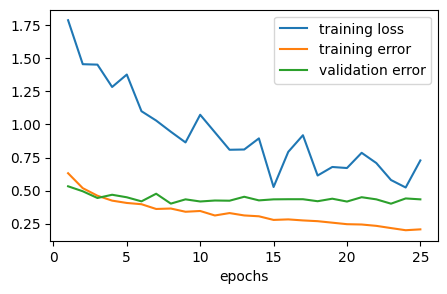

In [5]:
plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1),log_densenet[0],label='training loss')
plt.plot(np.arange(1,epochs+1),1-log_densenet[1],label='training error')
plt.plot(np.arange(1,epochs+1),1-log_densenet[2],label='validation error')
plt.legend()
plt.xlabel('epochs')

### 1.4 Clean noisy data

In [20]:
model_densenet = NoisyNet(base_model='densenet')
model_densenet([X_train[1:2],y_noisy_train[1:2]])
model_densenet.load_weights('models/best_densenet.h5')

In [22]:
test_accuracy=(np.argmax(model_densenet.predict([X_test,y_noisy_test]),axis=-1)==y_clean_test).mean()
print('Test accuracy for label cleaning is: ',test_accuracy)

32/32 [==============================] - 4s 58ms/step
Test accuracy for label cleaning is:  0.569


#### Generating cleaned label using trained network
Loading noisy data...

In [13]:
image_list_classify=[]
noisy_label_list_classify=[]
for file in tqdm(os.listdir(train_classifier)):
#     print("Reading folder {}".format(file))
    filename = os.fsdecode(file)
    filenum = int(filename[:5])
    image_list_classify.append(np.array(Image.open(os.path.join(train_classifier,file))))
    noisy_label_list_classify.append(int(noisy.iloc[filenum-1]))
X_only_noisy=np.array(image_list_classify)
y_only_noisy=np.array(noisy_label_list_classify).reshape(len(noisy_label_list_classify),1)

100%|███████████████████████████████████| 40000/40000 [00:39<00:00, 1009.90it/s]


In [27]:
batch_size = 400
n = len(X_only_noisy) // batch_size
cleaned_labels_densenet = np.array([])
for i in tqdm(range(n)):
    batch = [X_only_noisy[i*batch_size:(i+1)*batch_size],y_only_noisy[i*batch_size:(i+1)*batch_size]]
    cleaned_labels_densenet = np.concatenate((cleaned_labels_densenet,np.argmax(model_densenet(batch),axis=-1)))
cleaned_labels_densenet = cleaned_labels_densenet.astype(int)
np.savetxt("../data/cleaned_labels/cleaned_labels_densenet.csv", cleaned_labels_densenet, delimiter=",")

100%|█████████████████████████████████████████| 100/100 [01:58<00:00,  1.19s/it]


In [26]:
cleaned_labels_densenet = pd.read_csv('../data/cleaned_labels_densenet.csv',header=None).to_numpy().flatten()
cleaned_labels_densenet.size

40000

# Conclusion:
#### Label cleaning network based on ResNet outperforms DenseNet102.